<a href="https://colab.research.google.com/github/Jeyharshini10/Infosys_Springboard/blob/main/milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi


Tue Sep 30 03:05:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install transformers datasets sentencepiece rouge-score
!pip install nltk


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=84a1531447143a2b39434714e16e2383d946092f7ef59934d1a496f95b664de0
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [3]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import matplotlib.pyplot as plt
from collections import Counter
import textwrap
import re
import requests
import ssl
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

print(" Libraries imported.")

 Libraries imported.


We will use two online text sources for this experiment:

1. Alice in Wonderland  
   URL: `https://www.gutenberg.org/files/11/11-0.txt`

2. Dracula  
   URL: `https://www.gutenberg.org/files/345/345-0.txt`

We limit each text to the first 3000 characters for faster processing.


In [5]:
import requests

url1 = "https://www.gutenberg.org/files/11/11-0.txt"   # Alice in Wonderland
url2 = "https://www.gutenberg.org/files/345/345-0.txt"  # Dracula

text1 = requests.get(url1).text[:3000]  # limit to first 3000 characters
text2 = requests.get(url2).text[:3000]

documents = [text1, text2]
print("Documents fetched successfully!")


Documents fetched successfully!


Step 2: T5 Summarization & Paraphrasing

The T5 model converts all NLP tasks into a text-to-text format  
We will first summarize the document, then perform paraphrasing on the summary using a T5 paraphrase model.


In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# T5 Summarization
def summarize_t5(text, min_len=50, max_len=150):
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    input_text = "summarize: " + text.strip().replace("\n"," ")
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(
        inputs, max_length=max_len, min_length=min_len, num_beams=4, length_penalty=2.0, early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# T5 Paraphrasing
def paraphrase_t5(text):
    model_name = "Vamsi/T5_Paraphrase_Paws"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    input_text = "paraphrase: " + text
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    paraphrase_ids = model.generate(inputs, max_length=256, num_beams=4, early_stopping=True)
    return tokenizer.decode(paraphrase_ids[0], skip_special_tokens=True)

# Run T5 on documents
for idx, doc in enumerate(documents):
    print(f"\n=== Document {idx+1} – T5 ===")
    t5_summary = summarize_t5(doc)
    t5_paraphrase = paraphrase_t5(t5_summary)
    print("\nT5 Summary:\n", t5_summary)
    print("\nT5 Paraphrase:\n", t5_paraphrase)



=== Document 1 – T5 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]


T5 Summary:
 a white rabbit with pink eyes pops down a rabbit-hole under the hedge . the rabbit-hole goes straight on like a tunnel for some way, and then drops down a very deep well . a jar of maps and pictures hung upon pegs were hung on a shelf .

T5 Paraphrase:
 A white rabbit with pink eyes pops down a rabbit hole under the hedge , the rabbit hole goes straight on like a tunnel for some way and then drops down a very deep well , a jar of maps and pictures hung on pegs were hung on a shelf .

=== Document 2 – T5 ===

T5 Summary:
 a history almost at variance with the possibilities of later-day belief may stand forth as simple fact . all needless matters have been eliminated, so that a history almost at variance with the possibilities of later-day belief may stand forth as simple fact .

T5 Paraphrase:
 a history almost at variance with the possibilities of later-day belief may stand forth as simple fact , all needless matters have been eliminated , so that a history almost at vari

 Load and Clean Text from a URL

We will fetch a text file from a URL and clean it by:
1. Removing unnecessary newlines.
2. Removing extra spaces.
3. Keeping only readable text.


In [7]:
import requests
import re

# URL of the text file
url = "https://www.gutenberg.org/files/11/11-0.txt"  # Alice in Wonderland

# Fetch the text
response = requests.get(url)
raw_text = response.text

# Clean the text
# Replace multiple spaces, tabs, and newlines with a single space
clean_text = re.sub(r'\s+', ' ', raw_text).strip()

# Optional: limit to first 3000 characters for faster processing
clean_text = clean_text[:3000]

# Preview the first 500 characters
print(clean_text[:500])


*** START OF THE PROJECT GUTENBERG EBOOK 11 *** [Illustration] Alice’s Adventures in Wonderland by Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 Contents CHAPTER I. Down the Rabbit-Hole CHAPTER II. The Pool of Tears CHAPTER III. A Caucus-Race and a Long Tale CHAPTER IV. The Rabbit Sends in a Little Bill CHAPTER V. Advice from a Caterpillar CHAPTER VI. Pig and Pepper CHAPTER VII. A Mad Tea-Party CHAPTER VIII. The Queen’s Croquet-Ground CHAPTER IX. The Mock Turtle’s Story CHAPTER X. The Lobster


Step 3: BART Summarization

The BART model is bidirectional and autoregressive, useful for abstractive summarization tasks.  
We will summarize the same documents using BART for comparison.


In [8]:
from transformers import BartTokenizer, BartForConditionalGeneration

def summarize_bart(text, min_len=50, max_len=150):
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(
        inputs['input_ids'], max_length=max_len, min_length=min_len, num_beams=4, length_penalty=2.0, early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

for idx, doc in enumerate(documents):
    print(f"\n=== Document {idx+1} – BART ===")
    bart_summary = summarize_bart(doc)
    print("\nBART Summary:\n", bart_summary)



=== Document 1 – BART ===


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]


BART Summary:
 *** START OF THE PROJECT GUTENBERG EBOOK 11 *** UNCLASSIFIEDCLASSIFIEDCLASSIFIEDCHAPTER I.    Alice’s Adventures in Wonderland UNCLASSIFIED UNCLASSIFIED[Illustration] UNCLASSIFIEDCLASSIFIEDCHAPTER II. Â  The Rabbit Sends in a Little Bill of Tears UNCLASSIFIED CHAPTER III.  .  The Bunny Sends In a Big Bill of Shampooby Lewis Carroll UNCLASSIFIED UNCLASSIFIEDTHE MILLENNIUM FULCRUM EDITION 3.0 UNCLASSIFIED UNCLASSIFIEDCHAPTER I, and the Rabbit-HoleReloaded CHAPTER II. I   The Pool of Tears unden CHAPTER I. d   A Caucus-Race and a Long Tale of the White Rabbit’S Story unden CHAMPION CHAPTER IV

=== Document 2 – BART ===

BART Summary:
 *** START OF THE PROJECT GUTENBERG EBOOK 345 *** �􀀠\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\                                                                                      d  Â   .   (  �   T   D   I   DRACULA’S PRODUCTION-LOOKING SYST

Step 4: Pegasus Summarization

Pegasus is pre-trained specifically for **abstractive summarization** by predicting missing sentences in documents.  
We will summarize the same documents using Pegasus for comparison.


In [9]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

def summarize_pegasus(text, min_len=50, max_len=150):
    tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    summary_ids = model.generate(
        inputs['input_ids'], max_length=max_len, min_length=min_len, num_beams=4, length_penalty=2.0, early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

for idx, doc in enumerate(documents):
    print(f"\n=== Document {idx+1} – Pegasus ===")
    pegasus_summary = summarize_pegasus(doc)
    print("\nPegasus Summary:\n", pegasus_summary)



=== Document 1 – Pegasus ===


tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]


Pegasus Summary:
 Alice was sitting by the bank, and had no idea what to do with herself, for she had never before seen a rabbit in a field, and had never before seen a waistcoat in a field, and had never before seen a watch in a field, and had never before seen a daisy-chain in a field, and had never before seen a rabbit in a field, and had never before seen a watch in a field, and had never before seen a rabbit in a field.

=== Document 2 – Pegasus ===


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Pegasus Summary:
 The following is a statement of the history of The Dailygraph, which has been published in the United States for more than 100 years, and which has been translated into more than 30 languages.., by Bram Stoker, with permission from the Library of Congress, Washington, DC


Step 5: Model Comparison

We compare the **summary lengths** (number of words) produced by each model.  
A heatmap will visualize which model produces longer or shorter summaries for each document.


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


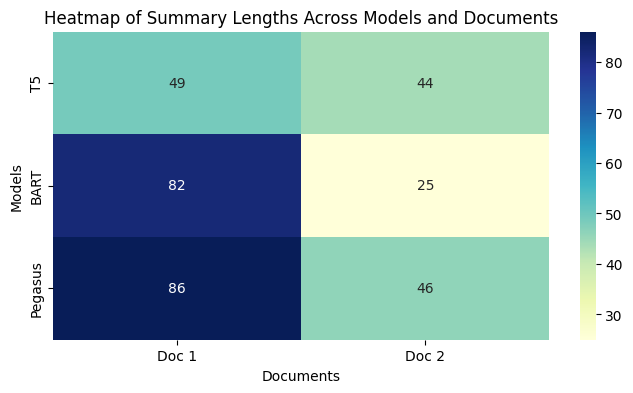

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

summary_lengths = {"T5": [], "BART": [], "Pegasus": []}

for doc in documents:
    summary_lengths["T5"].append(len(summarize_t5(doc).split()))
    summary_lengths["BART"].append(len(summarize_bart(doc).split()))
    summary_lengths["Pegasus"].append(len(summarize_pegasus(doc).split()))

heatmap_data = [
    summary_lengths["T5"],
    summary_lengths["BART"],
    summary_lengths["Pegasus"]
]

model_names = ["T5", "BART", "Pegasus"]
document_names = [f"Doc {i+1}" for i in range(len(documents))]

plt.figure(figsize=(8,4))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", xticklabels=document_names, yticklabels=model_names)
plt.title("Heatmap of Summary Lengths Across Models and Documents")
plt.xlabel("Documents")
plt.ylabel("Models")
plt.show()



In this example, we will:

1. Load a text file from a URL.
2. Clean the text.
3. Summarize it using T5, BART, and Pegasus.
4. Compare summary lengths using a bar chart.


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 Summary:
 a white rabbit with pink eyes pops down a rabbit-hole under the hedge . the rabbit-hole goes straight on like a tunnel for some way, and then dipped down . a jar of maps and pictures hung upon pegs, but it was empty as she fell . 

BART Summary:
 *** START OF THE PROJECT GUTENBERG EBOOK 11 *** [Illustration] Alice’s Adventures in Wonderland by Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 Contents CHAPTER I. Down the Rabbit-Hole CHAPTER II. The Pool of Tears CHAPTER III. A Caucus-Race and a Long Tale CHAPTER IV. The Rabbit Sends in a Little Bill CHAPTER V. Advice from a Caterpillar CHAPTER VI. Pig and Pepper CHAPTER VII. A Mad Tea-Party CHAPTER VIII. The Queen’S Croquet-Ground CHAPTER IX. The Mock Turtle CHAPTER X. The Lobster Quadrille CHAPTER XI. Who St 

Pegasus Summary:
 Alice was sitting by the bank, and had no idea what to do with herself, for she had never before seen a rabbit in a field, and had never before seen a waistcoat in a field, and had never before seen

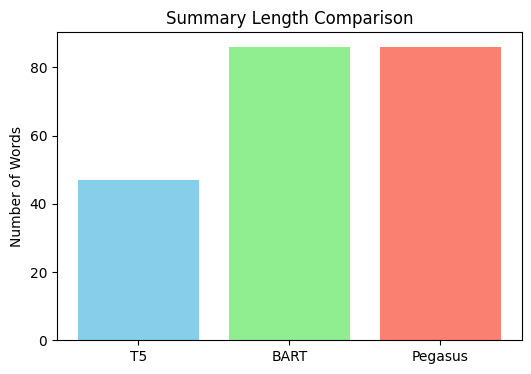

In [11]:
import requests
import re
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Load and clean text
# -------------------------------
url = "https://www.gutenberg.org/files/11/11-0.txt"  # Alice in Wonderland
response = requests.get(url)
raw_text = response.text

# Clean text: remove extra spaces, newlines, tabs
clean_text = re.sub(r'\s+', ' ', raw_text).strip()
# Optional: limit length for faster processing
clean_text = clean_text[:3000]

# -------------------------------
# Step 2: Define summarization functions
# -------------------------------
def summarize_t5(text):
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    input_text = "summarize: " + text
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=150, min_length=50, num_beams=4, length_penalty=2.0, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_bart(text):
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=50, num_beams=4, length_penalty=2.0, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_pegasus(text):
    tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=50, num_beams=4, length_penalty=2.0, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# -------------------------------
# Step 3: Generate summaries
# -------------------------------
t5_summary = summarize_t5(clean_text)
bart_summary = summarize_bart(clean_text)
pegasus_summary = summarize_pegasus(clean_text)

# Print summaries
print("T5 Summary:\n", t5_summary, "\n")
print("BART Summary:\n", bart_summary, "\n")
print("Pegasus Summary:\n", pegasus_summary, "\n")

# -------------------------------
# Step 4: Compare summary lengths
# -------------------------------
summary_lengths = {
    "T5": len(t5_summary.split()),
    "BART": len(bart_summary.split()),
    "Pegasus": len(pegasus_summary.split())
}

# -------------------------------
# Step 5: Plot bar chart
# -------------------------------
plt.figure(figsize=(6,4))
plt.bar(summary_lengths.keys(), summary_lengths.values(), color=['skyblue','lightgreen','salmon'])
plt.title("Summary Length Comparison")
plt.ylabel("Number of Words")
plt.show()


T5 Paraphrasing

We will use a pretrained T5 paraphrase model to generate a paraphrased version of the text.  
This helps in generating alternative expressions while keeping the meaning intact.


In [12]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Function to paraphrase text using T5
def paraphrase_t5(text):
    model_name = "Vamsi/T5_Paraphrase_Paws"  # Pretrained T5 paraphrase model
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    # Prepare input for the model
    input_text = "paraphrase: " + text
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate paraphrase
    paraphrase_ids = model.generate(inputs, max_length=256, num_beams=4, early_stopping=True)
    paraphrased_text = tokenizer.decode(paraphrase_ids[0], skip_special_tokens=True)
    return paraphrased_text

# Example usage
original_text = "Alice was beginning to get very tired of sitting by her sister on the bank."
paraphrased_text = paraphrase_t5(original_text)

print("Original Text:\n", original_text)
print("\nParaphrased Text:\n", paraphrased_text)


Original Text:
 Alice was beginning to get very tired of sitting by her sister on the bank.

Paraphrased Text:
 Alice was beginning to get very tired of sitting by her sister on the bank .


 Pegasus Paraphrasing

Although Pegasus is mainly used for summarization, it can be used to generate paraphrased versions of text in an abstractive way.


In [13]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# Function to "paraphrase" text using Pegasus
def paraphrase_pegasus(text, max_len=100, min_len=30):
    # Use the pre-trained Pegasus XSUM model
    model_name = "google/pegasus-xsum"
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)

    # Encode the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    # Generate output
    paraphrase_ids = model.generate(
        inputs['input_ids'],
        max_length=max_len,
        min_length=min_len,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    # Decode output
    paraphrased_text = tokenizer.decode(paraphrase_ids[0], skip_special_tokens=True)
    return paraphrased_text

# Example usage
original_text = "Alice was beginning to get very tired of sitting by her sister on the bank."
pegasus_paraphrase = paraphrase_pegasus(original_text)

print("Original Text:\n", original_text)
print("\nPegasus Paraphrased Text:\n", pegasus_paraphrase)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original Text:
 Alice was beginning to get very tired of sitting by her sister on the bank.

Pegasus Paraphrased Text:
 This is the story of Alice and her sister, who had been having a bit of a problem with each other at the bank, so Alice decided to take matters into her own hands and asked her sister to sit next to her.
